In [90]:
import numpy as np
import matplotlib.pyplot as plt
cor_list,phi_list = [],[]

# ----------------------------
# Parameters (free parameters)
# ----------------------------
L = 10.0          # domain length
N = 1000            # number of spatial grid points
dx = L / N         # spatial resolution
dt = 0.01          # time step
T = 10.0           # final time
steps = int(T / dt)

b = 2.0            # birth rate
d = 1           # intrinsic death rate
dprime = 0.1       # competition rate
lam = 1          # initial density (individuals per unit length)

sigma_m = 1.0      # std. of dispersal (birth) kernel
sigma_w = 0.1      # std. of competition kernel

# ----------------------------
# Set up spatial grid and kernels
# ----------------------------
x = np.linspace(-L/2, L/2, N, endpoint=False)

for i in range(100):

    # Compute periodic distances (using minimum image convention)
    def periodic_distance(x_i, x_j, L):
        dx = x_j - x_i
        return dx - L * np.round(dx / L)

    # Build kernel matrices: kappa_ij and w_ij
    kappa = np.zeros((N, N))
    w_kernel = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            dist = periodic_distance(x[i], x[j], L)
            # Truncated normal: value is 0 if outside [-L/2, L/2] (but here domain is [-L/2,L/2])
            kappa[i, j] = np.exp(-dist**2 / (2*sigma_m**2))
            w_kernel[i, j] =1 / (2 * np.pi)**(1/2) * np.exp(-dist**2 / (2*sigma_w**2))

    # Normalize birth kernel so that sum_j kernel_ij * dx = 1
    kappa /= (np.sum(kappa, axis=1, keepdims=True) * dx)

    # ----------------------------
    # Initial condition: PPP with density lam
    # ----------------------------
    # For each cell, sample number of individuals from Poisson(lam*dx)
    n_init = np.random.poisson(lam * dx, size=N)
    # Define phi as density: number / dx
    phi = n_init.astype(float) / dx

    # For storing the density profile over time (if desired)
    phi_time = np.zeros((steps, N))
    phi_time[0, :] = phi.copy()

    # ----------------------------
    # Euler-Maruyama Integration
    # ----------------------------
    for n in range(1, steps):
        # Compute convolution sums
        # Birth term: convolution with kappa
        birth_conv = dx * (kappa @ phi)
        # Competition term: convolution with w
        comp_conv = dx * (w_kernel @ phi)

        # Deterministic drift
        drift = b * birth_conv - d * phi - dprime * phi * comp_conv

        # Noise amplitude (variance per dt)
        Gamma = b * birth_conv + d * phi + dprime * phi * comp_conv
        # Ensure non-negative noise amplitude
        Gamma = np.maximum(Gamma, 0)

        # Generate Gaussian noise (independent at each grid point)
        noise = np.sqrt(Gamma) * np.random.normal(0, 1, size=N)

        # Euler-Maruyama update
        phi = phi + dt * drift + np.sqrt(dt) * noise

        # Enforce non-negativity (density cannot be negative)
        phi = np.maximum(phi, 0)

        phi_time[n, :] = phi.copy()

    # ----------------------------
    # Post-processing: compute mean density and pair correlation
    # ----------------------------
    mean_density = np.mean(phi)
    print("Mean density at T =", T, "is", mean_density)
    phi_list.append(phi)

    # Compute pair correlation as the spatial autocorrelation of phi.
    # Here we compute a simple auto-correlation function.
    phi_fluc = phi - np.mean(phi)
    corr = np.correlate(phi_fluc, phi_fluc, mode='full')
    corr = corr[corr.size//2:]  # positive lags
    lags = np.arange(0, len(corr)) * dx
    corr /= np.max(corr)
    cor_list.append(corr)

Mean density at T = 10.0 is 99.35573126144999
Mean density at T = 10.0 is 99.7408364208058
Mean density at T = 10.0 is 99.3621522819243
Mean density at T = 10.0 is 99.37407171460065
Mean density at T = 10.0 is 100.44543385775664
Mean density at T = 10.0 is 99.98241847622263
Mean density at T = 10.0 is 99.23821251107996
Mean density at T = 10.0 is 99.89198283232999
Mean density at T = 10.0 is 99.15775957347343
Mean density at T = 10.0 is 99.70845983278888
Mean density at T = 10.0 is 99.10559362875071
Mean density at T = 10.0 is 99.77136788479817
Mean density at T = 10.0 is 99.54558576530187
Mean density at T = 10.0 is 99.88795115671066
Mean density at T = 10.0 is 99.75778874449487
Mean density at T = 10.0 is 99.77920148367522
Mean density at T = 10.0 is 99.49463917735734
Mean density at T = 10.0 is 99.46071018100254
Mean density at T = 10.0 is 99.3372353367276
Mean density at T = 10.0 is 99.72474684820196
Mean density at T = 10.0 is 100.00871496808018
Mean density at T = 10.0 is 99.7498

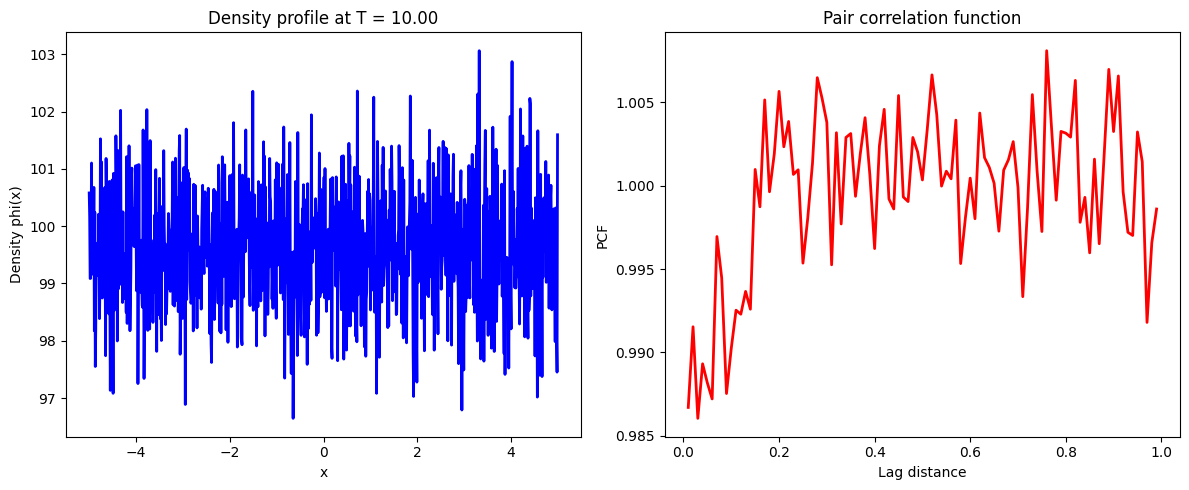

In [92]:
corr_mean = np.mean(np.array(cor_list),axis=0)
lags = np.arange(0, len(corr_mean)) * dx
phi_mean = np.mean(np.array(phi_list),axis=0)
# ----------------------------
# Plotting results
# ----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(x, phi_mean, 'b-', lw=2)
plt.xlabel('x'); plt.ylabel('Density phi(x)')
plt.title('Density profile at T = {:.2f}'.format(T))

plt.subplot(1,2,2)
plt.plot(lags[1:100], corr_mean[1:100]+1, 'r-', lw=2)
plt.xlabel('Lag distance'); plt.ylabel('PCF')
plt.title('Pair correlation function')
plt.tight_layout()
plt.show()


In [93]:
np.mean(phi_mean)

np.float64(99.60651868556886)